In [ ]:
# Downloads audio data for augmentation
# Borrowed from openWakeWord's automatic_model_training.ipynb, accessed March 4, 2024

import datasets
import scipy
import os

import numpy as np

from pathlib import Path
from tqdm import tqdm

## Download MIR RIR data

output_dir = "./mit_rirs"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    rir_dataset = datasets.load_dataset("davidscripka/MIT_environmental_impulse_responses", split="train", streaming=True)
    # Save clips to 16-bit PCM wav files
    for row in tqdm(rir_dataset):
        name = row['audio']['path'].split('/')[-1]
        scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))

## Download noise and background audio

# Audioset Dataset (https://research.google.com/audioset/dataset/index.html)
# Download one part of the audioset .tar files, extract, and convert to 16khz
# For full-scale training, it's recommended to download the entire dataset from
# https://huggingface.co/datasets/agkphysics/AudioSet, and
# even potentially combine it with other background noise datasets (e.g., FSD50k, Freesound, etc.)

if not os.path.exists("audioset"):
    os.mkdir("audioset")

    fname = "bal_train09.tar"
    out_dir = f"audioset/{fname}"
    link = "https://huggingface.co/datasets/agkphysics/AudioSet/resolve/main/data/" + fname
    !wget -O {out_dir} {link}
    !cd audioset && tar -xvf bal_train09.tar

    output_dir = "./audioset_16k"
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    # Save clips to 16-bit PCM wav files
    audioset_dataset = datasets.Dataset.from_dict({"audio": [str(i) for i in Path("audioset/audio").glob("**/*.flac")]})
    audioset_dataset = audioset_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))
    for row in tqdm(audioset_dataset):
        name = row['audio']['path'].split('/')[-1].replace(".flac", ".wav")
        scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))

# Free Music Archive dataset
# https://github.com/mdeff/fma

output_dir = "./fma"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    fma_dataset = datasets.load_dataset("rudraml/fma", name="small", split="train", streaming=True)
    fma_dataset = iter(fma_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000)))

    # Save clips to 16-bit PCM wav files
    n_hours = 1  # use only 1 hour of clips for this example notebook, recommend increasing for full-scale training
    for i in tqdm(range(n_hours*3600//30)):  # this works because the FMA dataset is all 30 second clips
        row = next(fma_dataset)
        name = row['audio']['path'].split('/')[-1].replace(".mp3", ".wav")
        scipy.io.wavfile.write(os.path.join(output_dir, name), 16000, (row['audio']['array']*32767).astype(np.int16))
        i += 1
        if i == n_hours*3600//30:
            break
        
        

In [22]:
# Specify parameters for augmentation

audio_config = {}

# audio_config['features_output_dir'] = '/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/vad_data/positive/musan_speech_split_validation_mmap'
# audio_config['features_output_dir'] = '/Volumes/MachineLearning/training_data/vad/negative/training/fsd50k_traininn_short_duration_1_mmap'

audio_config['input_path'] = '/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/piper-sample-generator/output/alexa/positive_better_phonetic'
audio_config['input_glob'] = '**/*.wav'
audio_config['impulse_paths'] = ['/Volumes/MachineLearning/audio_samples/background_noise_samples/wav_16k/bird_rir_all_channels_16k']
audio_config['background_paths'] = ['/Volumes/MachineLearning/audio_samples/background_noise_samples/background_clips_for_mixing']
audio_config['min_clip_duration_s'] = None
audio_config['max_clip_duration_s'] = 1.37
audio_config['max_start_time_from_right_s'] = None
audio_config['max_jitter_s'] = 0.2
audio_config['min_jitter_s'] = 0.05
audio_config['augmented_duration_s'] = 3.99

from microwakeword.feature_generation import ClipsHandler

In [23]:
# Load audio clips and prepare them for augmentation

clips_handler = ClipsHandler(
                            input_path=audio_config['input_path'],
                            input_glob=audio_config['input_glob'],
                            impulse_paths=audio_config['impulse_paths'], 
                            background_paths=audio_config['background_paths'], 
                            augmentation_probabilities = {
                                "SevenBandParametricEQ": 0.0,
                                "TanhDistortion": 0.0,
                                "PitchShift": 0.0,
                                "BandStopFilter": 0.0,
                                "AddColorNoise": 0.25,
                                "AddBackgroundNoise": 0.75,
                                "Gain": 1.0,
                                "RIR": 0.5,
                            },
                            augmented_duration_s = audio_config['augmented_duration_s'],
                            max_start_time_from_right_s = audio_config['max_start_time_from_right_s'],
                            max_jitter_s = audio_config['max_jitter_s'],
                            min_jitter_s = audio_config['min_jitter_s'],
                            max_clip_duration_s = audio_config['max_clip_duration_s'],   
                            min_clip_duration_s = audio_config['min_clip_duration_s'],  
                            random_split_seed=10,   
                            split_count=0.1,
                            remove_silence=False,
                            truncate_clip_s=None,
                            repeat_clip_min_duration_s=None,
)


In [26]:
# Test by playing a randomly augmented clip

import IPython

clips_handler.save_random_augmented_clip("augmented_clip.wav")

IPython.display.display(IPython.display.Audio("augmented_clip.wav"))

In [16]:
# # Save all the clip's augmented features in a Ragged Mmap
# for i in range(0,1):
#     # audio_config['features_output_dir'] = '/Volumes/MachineLearning/training_data/hey_mycroft_hand_filtered/training/training_{}_mmap'.format(str(i))
#     # print(audio_config['features_output_dir'])

import os

output_dir_base = '/Volumes/MachineLearning/training_data/alexa/positive_min_end_jitter'
categories = ['testing', 'validation']#, 'training']

for cat in categories:
    output_mmap_path = os.path.join(output_dir_base, cat, 'alexa_'+cat+'_mmap')
    # print(output_mmap_path)
    if cat == 'testing':
        clips_handler.save_augmented_features(output_mmap_path, split='test', repeat=1)
    elif cat == 'validation':
        clips_handler.save_augmented_features(output_mmap_path, split='validation', repeat=1)
    elif cat == 'training':
        clips_handler.save_augmented_features(output_mmap_path, split='train', repeat=1)

0it [00:00, ?it/s]2024-05-12 07:37:59.292055: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-12 07:37:59.292101: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-12 07:37:59.292116: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-12 07:37:59.292178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-12 07:37:59.292198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
7401it [02:11, 56.18it/s]
7401it [02:05, 59.09it/s]


In [20]:
# Specify parameters for augmentation

audio_config = {}

audio_config['input_path'] = '/Volumes/MachineLearning/audio_samples/background_noise_samples/extracted_raw/CHiME6/train'
audio_config['input_glob'] = '**/*CH1*.wav'
audio_config['impulse_paths'] = None#['/Volumes/MachineLearning/audio_samples/background_noise_samples/extracted_raw/BUT_ReverbDB_rel_19_06_RIR-Only']
audio_config['background_paths'] = None#['/Volumes/MachineLearning/audio_samples/background_noise_samples/background_clips_for_mixing']
audio_config['min_clip_duration_s'] = None
audio_config['max_clip_duration_s'] = None
audio_config['max_start_time_from_right_s'] = None
audio_config['max_jitter_s'] = None
audio_config['augmented_duration_s'] = None

from microwakeword.feature_generation import ClipsHandler

In [21]:
# Load audio clips and prepare them for augmentation

clips_handler = ClipsHandler(
                            input_path=audio_config['input_path'],
                            input_glob=audio_config['input_glob'],
                            impulse_paths=audio_config['impulse_paths'], 
                            background_paths=audio_config['background_paths'], 
                            augmentation_probabilities = {
                                "SevenBandParametricEQ": 0.0,
                                "TanhDistortion": 0.0,
                                "PitchShift": 0.0,
                                "BandStopFilter": 0.0,
                                "AddBackgroundNoise": 0.0,
                                "Gain": 0.0,
                                "RIR": 0.0,
                            },
                            augmented_duration_s = audio_config['augmented_duration_s'],
                            max_start_time_from_right_s = audio_config['max_start_time_from_right_s'],
                            max_jitter_s = audio_config['max_jitter_s'],
                            max_clip_duration_s = audio_config['max_clip_duration_s'],   
                            min_clip_duration_s = audio_config['min_clip_duration_s'],
                            remove_silence=False,
                            truncate_clip_s=None,
                            repeat_clip_min_duration_s=6,
                            split_spectrogram_duration_s=5,
)
print(len(clips_handler.clips))

KeyError: 'AddColorNoise'

In [31]:
# Test by playing a randomly augmented clip

import IPython

clips_handler.save_random_augmented_clip("augmented_clip.wav")

IPython.display.display(IPython.display.Audio("augmented_clip.wav"))

In [38]:
clips_handler.save_augmented_features('/Volumes/MachineLearning/training_data/negative_datasets/dinner_party_background_new/chime_6_ch1_5s_split_training_mmap', split=None, repeat=1)

0it [00:00, ?it/s]UserWarning:
169233it [32:31, 86.74it/s] 


In [1]:
from microwakeword.room_simulation_feature_generation import RoomClipsHandler
clips_handler = RoomClipsHandler(
                            input_path='/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/piper-sample-generator/output/alexa/positive_better_phonetic',
                            input_glob='**/*.wav',
                            impulses_path='/Volumes/MachineLearning/audio_samples/background_noise_samples/wav_16k/bird_rir_all_channels_16k',
                            impulses_glob='**/*.wav',
                            background_path='/Volumes/MachineLearning/audio_samples/background_noise_samples/background_clips_for_mixing', 
                            background_glob='**/*.wav',
                            playback_background_path='/Volumes/MachineLearning/audio_samples/background_noise_samples/background_clips_for_mixing/fma',
                            playback_background_glob='**/*.wav',
                            augmented_duration_s = 3.99,
                            max_start_time_from_right_s = None,
                            max_jitter_s = 0.2,
                            min_jitter_s = 0.05,
                            max_clip_duration_s = 1.39,   
                            min_clip_duration_s = None,
                            background_probability = 1,
                            playback_background_probability = 1,
)

In [9]:
import IPython

clips_handler.save_random_augmented_clip("augmented_clip.wav")

IPython.display.display(IPython.display.Audio("augmented_clip.wav"))

(199, 40)
(199, 80)


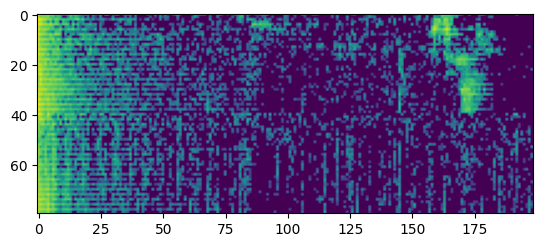

In [8]:
features = clips_handler.generate_random_augmented_spectrogram()
import matplotlib.pyplot as plt

import numpy as np
plt.imshow(np.transpose(features))
print(features.shape)